## Build MRCNN Model -Load MRCNN and FCN weights - Load Training Files  

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import copy    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib          import cm
import mrcnn.utils       as utils
import mrcnn.visualize   as visualize
import mrcnn.visualize  as vis
import mrcnn.visualize_2 as vis2
from mrcnn.prep_notebook import build_fcn_inference_pipeline_newshapes, build_fcn_evaluate_pipeline_newshapes
from mrcnn.prep_notebook import get_inference_batch, get_evaluate_batch, get_image_batch
from mrcnn.prep_notebook import run_mrcnn_detection, run_fcn_detection, run_fcn_evaluation
from mrcnn.newshapes     import prep_newshape_dataset
from mrcnn.visualize     import display_training_batch
# from mrcnn.utils         import trim_zeros, compute_overlaps
# from mrcnn.calculate_map import update_map_dictionaries

# WEIGHT_FILE = 'F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_2298.h5' 
# FCN_WEIGHT_FILE = 'F:\\models_newshapes\\train_fcn8_l2_newshapes\\fcn20181224T0000\\fcn_0821.h5'
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = utils.command_line_parser()
input_parms  =" --batch_size     1  "
input_parms +=" --dataset        newshapes2 "
input_parms +=" --mrcnn_logs_dir train_mrcnn "
input_parms +=" --fcn_logs_dir   train_fcn8L2_BCE1 " 
input_parms +=" --mrcnn_model    /home/kbardool/models_newshapes2/train_mrcnn/mrcnn20190318T0000/"+ "mrcnn_0020.h5 "
input_parms +=" --fcn_model      /home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn20190323T0000/" + "fcn_0089.h5"
input_parms +=" --fcn_arch       fcn8l2 " 
input_parms +=" --sysout         screen "
input_parms +=" --evaluate_method 3"
input_parms +=" --scale_factor    1"
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

CLASS_COLUMN        = 4
ORIG_SCORE_COLUMN   = 5
DT_TYPE_COLUMN      = 6
SEQUENCE_COLUMN     = 7
NORM_SCORE_COLUMN   = 8    
SCORE_0_SUM_COLUMN  = 9
SCORE_0_AREA_COLUMN = 10
SCORE_0_COLUMN      = 11
SCORE_1_SUM_COLUMN  = 12
SCORE_1_AREA_COLUMN = 13
SCORE_1_COLUMN      = 14 
SCORE_1_NORM_COLUMN = 17
SCORE_2_SUM_COLUMN  = 18
SCORE_2_AREA_COLUMN = 19
SCORE_2_COLUMN      = 20
SCORE_2_NORM_COLUMN = 23

Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks
appending '..' to sys.path


Using TensorFlow backend.


 Init Image Class - Possible Object Choices:  {'truck': 3, 'building': 3, 'sun': 1, 'airplane': 3, 'tree': 5, 'person': 5, 'cloud': 3, 'car': 3}
 Init Image Class - Custom Color Keys      :  ['ground', 'sky', 'sun', 'person', 'tree', 'cloud']
 Init Image Class - Object Priority List   :  ['building', 'tree', 'car']
 Init Image Class - BUILD_MAX_TRIES        :  7
 Init Image Class - PERSON_CAR_DISTANCE    :  10

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   dataset                        newshapes2
   epochs                         1
   evaluate_method                3
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['fcn32+']
   fcn_logs_dir                   train_fcn8L2_BCE1
   fcn_losses                     fcn_BCE_loss
   fcn_model                      /home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn201

## Load test dataset

In [7]:
# with open(os.path.join(mrcnn_model.config.DIR_DATASET,"newshapes2_test_dataset_1000_A.pkl"), 'rb') as infile:
with open(os.path.join("/home/kbardool/MLDatasets/newshapes2","newshapes2_test_dataset_1000_A.pkl"), 'rb') as infile:
    dataset_test = pickle.load(infile)
print(type(dataset_test))    

dataset_test.display_active_class_info()
print("Testing Dataset Image Count: {}".format(len(dataset_test.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_test.num_classes))
print(len(dataset_test.image_ids))    
class_names = dataset_test.class_names

<class 'mrcnn.newshapes2.NewImagesDataset'>
 Active Class Information 
--------------------------
[1, 2, 3, 4, 5, 6, 7, 8]
internal_class:  1 ext_cls: 1 category-name: None - person
internal_class:  2 ext_cls: 2 category-name: None - car
internal_class:  3 ext_cls: 3 category-name: None - sun
internal_class:  4 ext_cls: 4 category-name: None - building
internal_class:  5 ext_cls: 5 category-name: None - tree
internal_class:  6 ext_cls: 6 category-name: None - cloud
internal_class:  7 ext_cls: 7 category-name: None - airplane
internal_class:  8 ext_cls: 8 category-name: None - truck
Testing Dataset Image Count: 1000
Testing Dataset Class Count: 9
1000


###  Display some images from dataset

In [4]:
# image_list = list(range(160,200))
image_list = list(range(132, 132))
image_titles = [str(i) for i in image_list]
images = get_image_batch(dataset_test, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

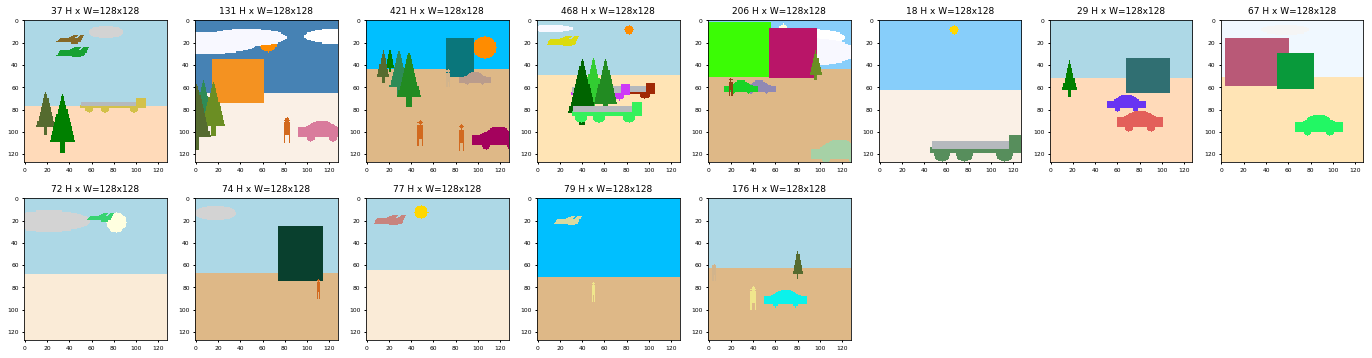

In [5]:
# image_list = list(range(160,200))
# image_list = list(range(0, 80))
image_list = [37, 131, 421, 468, 206 , 18, 29, 67, 72, 74, 77, 79, 176]
image_titles = [str(i) for i in image_list]

images = get_image_batch(dataset_test, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

##  Manipulate some images to test contextual relationships

|Exp |Image     | Original Image | modifications |Conxtextual experiment
|----| :------- |:-------------- | :-------------|:------------------------------------------------------------------ 
| 1 | Image 18 | sun and truck | Remove sun, add building |  move truck around with and without a building present in the image
| 2 | image 67 | Buildings and car|                    | If we move a person around the activation "should" peak when it's in proper position with regards to the car.
| 3 | image 67 | Buildings and car| Remove all objects | and move an object of each class around in black, and in color. 
| 4 | Image 72 | sun and airplane | Remove sun         | move a car around the image, and move a truck around the image , comparing the results. Moving a truck should invoke higher activation than a car, since the cars do not cooccur with an airplane
| 5 | Image 77 | Sun, Airplane    | Remove sun         | move airplane around with and and without a building present in the scene. The activation strength should increase when the building is absent
| 6 | Image 79 | Person, plane | Remove the plane | move a car around the image. Activation of the car should peak when it's in propoer position with regards to the person
| 7 | image 176| 2 persons, tree, car| Remove tree and persons | move a airplane around (car and airplane dont occur in same image - so the relatvie activation strength of the airplane, in proper position, should be higher when thecar is absent from the image
    
    - The max FCN activation of the person is close to the car
 

####  Objects to add / remove from image s

In [ ]:
## image 77: [('sun', (255.0, 215.0, 0.0), (49, 13, 6, 6)), ('airplane', (200.0, 132.0, 126.0), (25, 23, 18, 7))]
## image 27 : [ ('sun', (255.0, 255.0, 224.0), (87, 16, 7, 7)),   ('building', (7.0, 9.0, 197.0), (92, 60, 24, 20)),   ('person', (210.0, 105.0, 30.0), (124, 107, 2, 11))]

# del dataset_test.image_info[image_id]['shapes'][0:2]
# black_car  = ('car', black, (cx, cy, 15, 7))
# black_car = ('car', (0.0, 0.0, 0.0),(64,64, 15, 7))
# person = ('person', (139.0, 69.0, 19.0), (17, 92, 2, 10))
## person = ('person', (240.0, 230.0, 140.0), (40, 92, 2, 10))
## black_sun = ('sun', (0.0, 0.0, 0.0), (7, 9, 4, 4))
building  =  ('building', (7.0, 9.0, 197.0), (92, 60, 24, 20))
airplane  = ('airplane', (200.0, 132.0, 126.0), (25, 23, 18, 7))
car       = ('car', (150.0, 174.0, 8.0), (87, 112, 22, 11))
truck     = ('truck', (213.0, 56.0, 119.0), (80, 93, 39, 13))
truck     = ('truck', (83.0, 192.0, 78.0), (65, 71, 25, 8))
tree      = ('tree', (50.0, 205.0, 50.0), (100, 91, 12, 28))
cloud     = ('cloud', (192.0, 192.0, 192.0), (106, 20, 34, 8))
sun       = ('sun', (255.0, 140.0, 0.0), (66, 18, 7, 7)),

[ ('building', (48.0, 111.0, 114.0), (87, 50, 19, 15)),
  ('tree', (0.0, 128.0, 0.0), (17, 53, 6, 16)),
  ('car', (104.0, 52.0, 242.0), (68, 76, 17, 8)),
  ('car', (227.0, 95.0, 90.0), (80, 92, 20, 10))]
 Image_id    :  29  Reference:  [('building', (48.0, 111.0, 114.0), (87, 50, 19, 15)), ('tree', (0.0, 128.0, 0.0), (17, 53, 6, 16)), ('car', (104.0, 52.0, 242.0), (68, 76, 17, 8)), ('car', (227.0, 95.0, 90.0), (80, 92, 20, 10))] Coco Id: 29
 Image meta  :  [    29    128    128      3      0      0    128    128      1      1]
 Class ids   :  (4,)    [     4      5      2      2]
 Class Names :  ['building', 'tree', 'car', 'car']


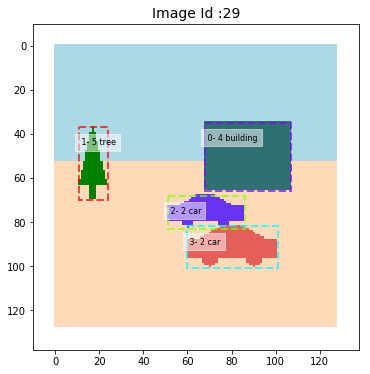

In [43]:
# pp.pprint(dataset_test.image_info[20]['shapes'])
show_id = 29
pp.pprint(dataset_test.image_info[show_id]['shapes'])
vis.display_image_gt(dataset_test, dataset_test.config, show_id, size=6, verbose = True)

## Helper functions 

In [8]:
np_format = {'float': lambda x: "%10.4f" % x, 'int': lambda x: "%8d" % x}
np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format), 

(None,)

In [9]:
def plot_fcn_score_curves(x_y_dim, fcn_scores, mrcnn_scores, class_names, ax = None , min_x = 0.0, title = None):
    if ax is None:
        plt.figure(figsize=(10,5))
        ax = plt.gca()

    # scores is always passed ffom plot_mAP_by_scores, so it's nver None
    # so we loop on scores instead of sorted(class_data)
    # for idx, score_key in enumerate(sorted(class_data)):
    for idx, cls  in enumerate(fcn_scores):
        ax.plot(x_y_dim, fcn_scores[cls], label= cls + ' - FCN score')
        # if  scores is not None and score_key not in  scores:
            # continue        
#         print('score_key is: {:20s} iou: {:6.3f}  avg_prec: {:10.4f}'.format(score_key,  iou_key, class_data[score_key][iou_key]['avg_prec']))
#         score_keys.append(score_key)
#         avg_precs[score_key] = class_data[score_key][iou_key]['avg_prec']
#         precisions = class_data[score_key][iou_key]['precisions']
#         recalls    = class_data[score_key][iou_key]['recalls']
#         label      = '{:15s}'.format(score_key)
        
#         score_idx  = scores.index(score_key)
#         print('idx: ', idx, ' Score_key: ' , score_key, 'Score Index: ' , score_idx, 'color:', SCORE_COLORS[score_key])
    
    for idx, cls  in enumerate(mrcnn_scores):
        ax.plot(x_y_dim, mrcnn_scores[cls], label= cls + ' - MR-CNN score')
        
    print(' y limit:', plt.ylim(), ' xlimit : ', plt.xlim())

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Object displacement from origin axis', fontsize= 12)
    ax.set_ylabel('FCN Score', fontsize= 12)
    ax.tick_params(axis='both', labelsize = 10)
#     ax.set_xlim([min_x,1.05])
#     ax.set_ylim([all_scores.min()-0.05, all_scores.max()+0.05])
    leg = plt.legend(loc='lower left',frameon=True, fontsize = 10, markerscale = 6)
    leg.set_title(' Scores ',prop={'size':11})
    plt.grid(True)
#     for xval in np.linspace(0.0, 1.0, 11):
#         plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=1)

def plot_fcn_score_curves_1(x_y_dim, cls_scores, cls_name, ax = None , min_x = 0.0, title = None):

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Object displacement from origin axis', fontsize= 12)
    ax.set_ylabel('FCN Score', fontsize= 12)
    ax.tick_params(axis='both', labelsize = 10)
#     ax.set_xlim([min_x,1.05])
#     ax.set_ylim([all_scores.min()-0.05, all_scores.max()+0.05])
    leg = plt.legend(loc='lower left',frameon=True, fontsize = 10, markerscale = 6)
    leg.set_title(' Scores ',prop={'size':11})
    plt.grid(True)
#     for xval in np.linspace(0.0, 1.0, 11):
#         plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=1)


def save_results(results, save_path, save_file):
    print(' Save to output file: ',save_path, save_file)
    np.savez_compressed(os.path.join(save_path, save_file),     
                    imgs_one_gt        = results['imgs_one_gt'], 
                    imgs_one_dt        = results['imgs_one_dt'],  
                    gt_cls_counts      = results['gt_cls_counts'], 
                    dt_cls_counts      = results['dt_cls_counts'],
                    gt_ttl_img_by_inst = results['gt_ttl_img_by_inst'],
                    dt_ttl_img_by_inst = results['dt_ttl_img_by_inst'],
                    sav_pr_min         = results['sav_pr_min']  ,
                    sav_pr_max         = results['sav_pr_max']  , 
                    sav_fcn_min        = results['sav_fcn_min'] , 
                    sav_fcn_max        = results['sav_fcn_max'] ,                     
                    pr_agg_hm          = results['pr_agg_hm']  ,
                    fcn_agg_hm         = results['fcn_agg_hm']  ,
                    pr_agg_hm_clipped  = results['pr_agg_hm_clipped'],
                    fcn_agg_hm_clipped = results['fcn_agg_hm_clipped'],
                    fcn_scores         = results['fcn_scores'],
                    pr_scores          = results['pr_scores'])     
    return 0


def display_results(results):
    np_format = {}
    np_format['float']  = lambda x: "%10.4f" % x
    np_format['int']    = lambda x: "%6d" % x
    np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)
    
    print()
    print(' Final Results:')
    print('---------------')
    print('  pr_hm MIN: {:12.5f}      MAX: {:12.5f}'.format(results['sav_pr_min'], results['sav_pr_max']))
    print(' fcn_hm MIN: {:12.5f}      MAX: {:12.5f}'.format(results['sav_fcn_min'], results['sav_fcn_max']))
    print()
    print(' images with one gt object:', results['imgs_one_gt'], '  one detection from MR-CNN:', results['imgs_one_dt'])
    print(' Ground Truth by class    :', results['gt_cls_counts'])
    print(' Detections by class      :', results['dt_cls_counts'])
    print()
    print(' Original Heatmap:')
    print(' ----------------')
    print('    pr_hm mins: ',np.min(results['pr_agg_hm'] , axis=(0,1)))
    print('          maxs: ',np.max(results['pr_agg_hm'] , axis=(0,1)))
    print()
    print('   fcn_hm mins: ',np.min(results['fcn_agg_hm'], axis=(0,1)))
    print('          maxs: ',np.max(results['fcn_agg_hm'], axis=(0,1)))
    print()
    print('   pr_hm sums : ',np.sum(results['pr_agg_hm'] , axis=(0,1)))
    print('   fcn_hm sums: ',np.sum(results['fcn_agg_hm'], axis=(0,1)))
    print()
    print(' Clipped Heatmap:')
    print(' ----------------')
    print('   pr_hm mins : ',np.min(results['pr_agg_hm_clipped'], axis=(0,1)))
    print('         maxs : ',np.max(results['pr_agg_hm_clipped'], axis=(0,1)))
    print('  fcn_hm mins : ',np.min(results['fcn_agg_hm_clipped'], axis=(0,1)))
    print('         maxs : ',np.max(results['fcn_agg_hm_clipped'], axis=(0,1)))
    print('   pr_hm sums : ',np.sum(results['pr_agg_hm_clipped'], axis=(0,1)))
    print('  fcn_hm sums : ',np.sum(results['fcn_agg_hm_clipped'], axis=(0,1)))

    print('\n gt_ttl_img_by_inst', results['gt_ttl_img_by_inst'].shape)
    print(' ------------------')
    print(results['gt_ttl_img_by_inst'][:,:16])
    print('\n dt_ttl_img_by_inst : ', results['dt_ttl_img_by_inst'].shape)
    print(' ------------------')
    print(results['dt_ttl_img_by_inst'][:,:16])
    return(0)

In [10]:
def aggregate_results(fcn_results, results, cx = None, cy= None):
    import mrcnn.score_columns
    r = fcn_results[0]
        
    gt_inst_per_class = np.bincount(np.abs(r['gt_class_ids']), minlength = NUM_CLASSES)
    dt_inst_per_class = np.bincount(r['class_ids']           , minlength = NUM_CLASSES)

    results['gt_cls_counts'] += gt_inst_per_class
    results['dt_cls_counts'] += dt_inst_per_class

    for i in range(NUM_CLASSES):
        results['gt_ttl_img_by_inst'][i,gt_inst_per_class[i]] += 1
        results['dt_ttl_img_by_inst'][i,dt_inst_per_class[i]] += 1


    if len(r['class_ids']) == 1: 
        results['imgs_one_dt'] += 1
    if len(r['gt_class_ids']) == 1:
        results['imgs_one_gt'] += 1

    fcn_hm_max   = np.max(r['fcn_hm'])
    fcn_hm_min   = np.min(r['fcn_hm'])
    pr_hm_max    = np.max(r['pr_hm'])
    pr_hm_min    = np.min(r['pr_hm'])
    
    if fcn_hm_max > results['sav_fcn_max'] :
        results['sav_fcn_max'] = fcn_hm_max

    if fcn_hm_min < results['sav_fcn_min'] :
        results['sav_fcn_min'] = fcn_hm_min

    if pr_hm_max > results['sav_pr_max']:
        results['sav_pr_max'] = pr_hm_max

    if pr_hm_min > results['sav_pr_min']:
        results['sav_pr_min'] = pr_hm_min
    
    results['pr_agg_hm']          += r['pr_hm']
    results['fcn_agg_hm']         += r['fcn_hm']
    results['pr_agg_hm_clipped']  += np.clip(r['pr_hm'], 0.0, 1.0)
    results['fcn_agg_hm_clipped'] += np.clip(r['fcn_hm'], 0.0, 1.0)
    
#     if cx is not None:
#         print(r['pr_scores'])
#         print(r['fcn_scores'])
    for row in r['fcn_scores'][::-1]:
        cls = int(row[CLASS_COLUMN])
#             print(' Class: {:d}   fcn_score_1 {}  fcn_score_2 {}'.format(
#                 cls, row[SCORE_1_COLUMN], row[SCORE_2_COLUMN]))
        results['fcn_scores'][0, cls,cx,cy] = row[SCORE_1_COLUMN]
        results['fcn_scores'][1, cls,cx,cy] = row[SCORE_2_COLUMN]

    for row in r['pr_scores'][::-1]:
        cls = int(row[CLASS_COLUMN])
#             print(' Class: {:d}  mrcnn_scr_1 {} mrcn_score_2 {}'.format(
#                 cls, row[SCORE_1_COLUMN], row[SCORE_2_COLUMN]))
        results['pr_scores'][0, cls,cx,cy] = row[SCORE_1_COLUMN]
        results['pr_scores'][1, cls,cx,cy] = row[SCORE_2_COLUMN]
    
    
    return results

## Heatmap aggregation over a number of images

## Display FCN output heatmaps for a series of epoch files

In [2]:
# MRCNN_DIR_WEIGHTS =  'F:/models_newshapes/train_mrcnn_newshapes/mrcnn20181216T0000'
MRCNN_DIR_WEIGHTS = '/home/kbardool/models_newshapes2/train_mrcnn/mrcnn20190318T0000'
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
# files   = ['fcn_0104.h5','fcn_0150.h5','fcn_0205.h5','fcn_0249.h5','fcn_0293.h5','fcn_0346.h5','fcn_0419.h5']
mrcnn_files   = ['mrcnn_0001.h5', 'mrcnn_0020.h5', 'mrcnn_0041.h5', 'mrcnn_0060.h5',
                 'mrcnn_0092.h5', 'mrcnn_0116.h5', 'mrcnn_0154.h5', 'mrcnn_0174.h5',
                 'mrcnn_0201.h5', 'mrcnn_0223.h5', 'mrcnn_0243.h5', 'mrcnn_0332.h5']

MRCNN_FILE_IDX = -2

In [1]:
# FCN_DIR_WEIGHTS =  'F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# fcn_files = ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5',
#              'fcn_0450.h5', 'fcn_0482.h5', 'fcn_0521.h5', 'fcn_0610.h5',
#              'fcn_0687.h5', 'fcn_0793.h5', 'fcn_0821.h5', 'fcn_0940.h5',
#              'fcn_1012.h5', 'fcn_1127.h5', 'fcn_1644.h5', 'fcn_1776.h5',
#               'fcn_1848.h5', 'fcn_2017.h5', 'fcn_2084.h5', 'fcn_x0434.h5', 'fcn_x0419.h5']
FCN_DIR_WEIGHTS =  '/home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn20190323T0000'
fcn_files  = ['fcn_0001.h5', 'fcn_0002.h5', 'fcn_0003.h5', 'fcn_0004.h5', 
              'fcn_0005.h5', 'fcn_0006.h5', 'fcn_0008.h5', 'fcn_0009.h5', 
              'fcn_0012.h5', 'fcn_0016.h5', 'fcn_0018.h5', 'fcn_0019.h5', 
              'fcn_0021.h5', 'fcn_0022.h5', 'fcn_0023.h5', 'fcn_0024.h5', 
              'fcn_0033.h5', 'fcn_0039.h5', 'fcn_0042.h5', 'fcn_0044.h5', 
              'fcn_0077.h5', 'fcn_0089.h5', 'fcn_0170.h5', 'fcn_0177.h5',
              'fcn_0253.h5', 'fcn_0266.h5']  ## 22,23,24,25
FILE_IDX = -1

In [9]:
save_path = "/home/kbardool/git_projs/mrcnn3/train_newshapes_2/other"
exp_prfx = 'exp6'
exp_desc = 'sun'
cols = 9 
image_id = 79

save_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' SAVED FILENAME:', save_file)

classes = [1,2,3,4,5,6,7,8]

for FILE_IDX in [25]:
    epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
    mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
    load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
    filename  = os.path.join(save_path, load_file)
    
    if os.path.exists(filename):
        print('  input file: ', filename)
        loaddata = np.load(os.path.join(save_path, load_file))
    else: 
        print('file not found ', filename)
        continue 
        
    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
    
    ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 SAVED FILENAME: exp6_i79_e0266_m0243_sun.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp6_i79_e0266_m0243_sun.npz


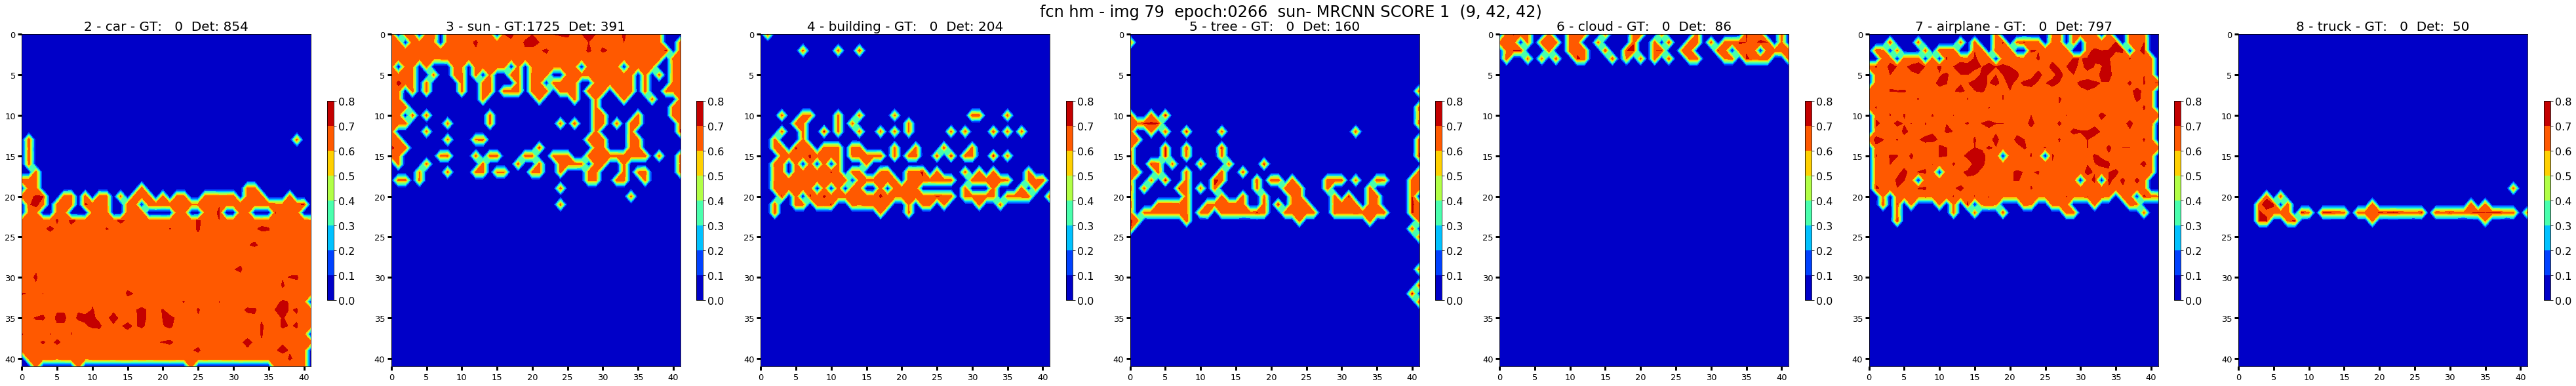

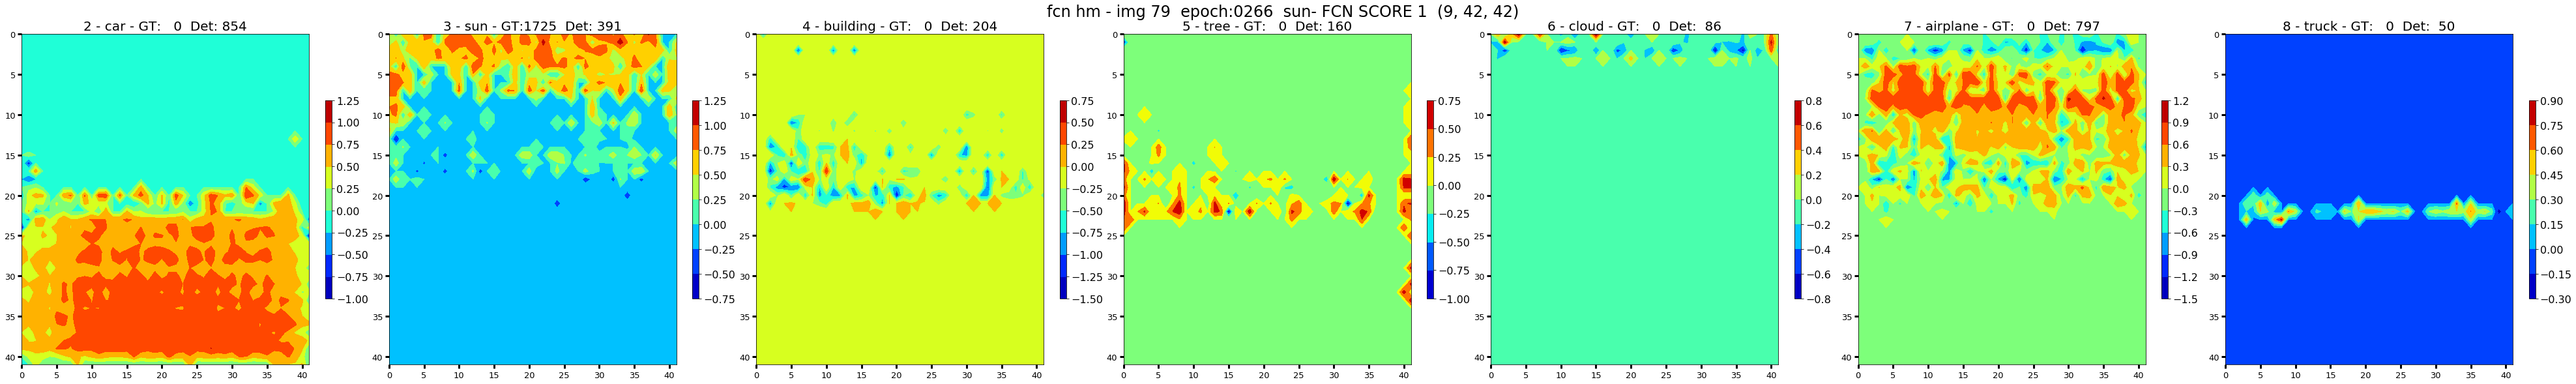

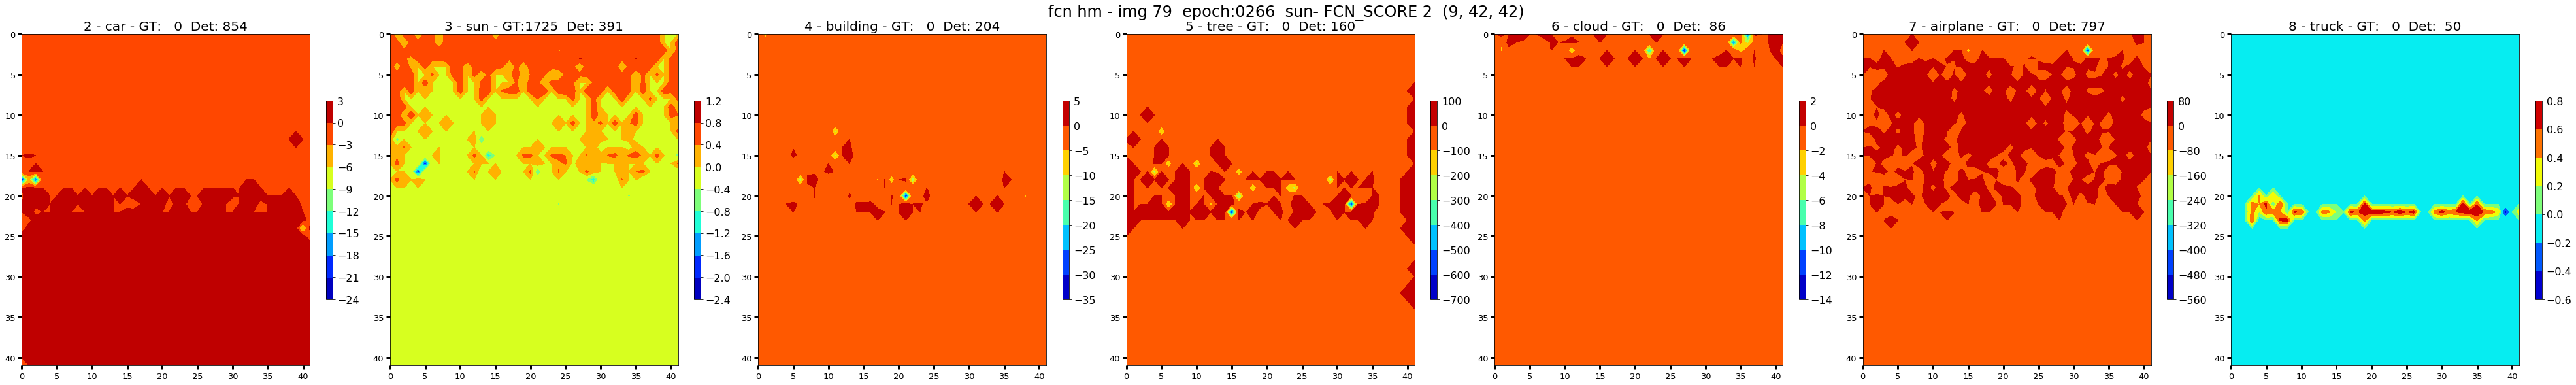

In [18]:
# print(ttl, cols)
classes = [1,2,3,4,5,6,7,8]
classes = [2,3,4,5,6,7,8]

_ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)


exp6_i79_e0266_m0243_sun.npz
 Num features:  2 Rows / Columns:  2 3


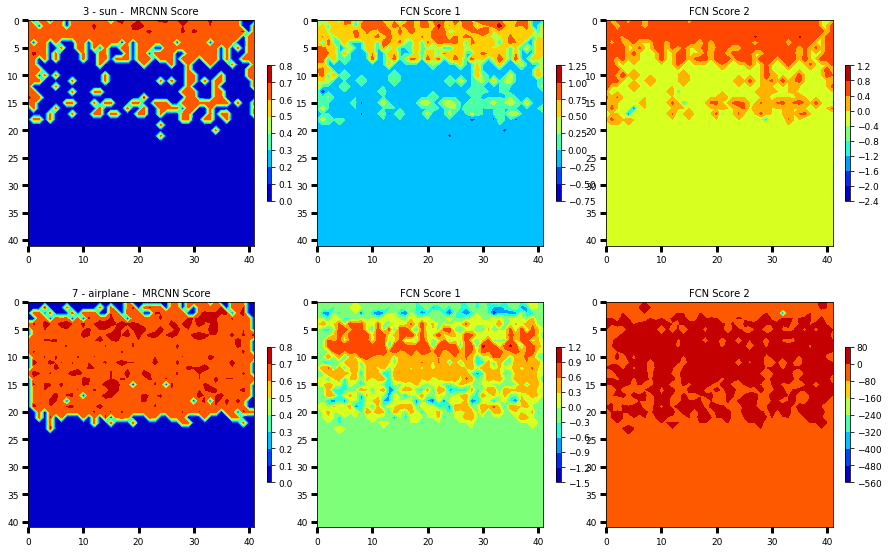

In [28]:
classes = [1,2,3,4,5,6,7,8]
classes = [3,7]
print(save_file)
_ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes)

(9, 1, 1)


../mrcnn/visualize_2.py:905: RuntimeWarning: invalid value encountered in true_divide
  out /= (x.max(axis=(1,2), keepdims = True) - x.min(axis=(1,2), keepdims = True))


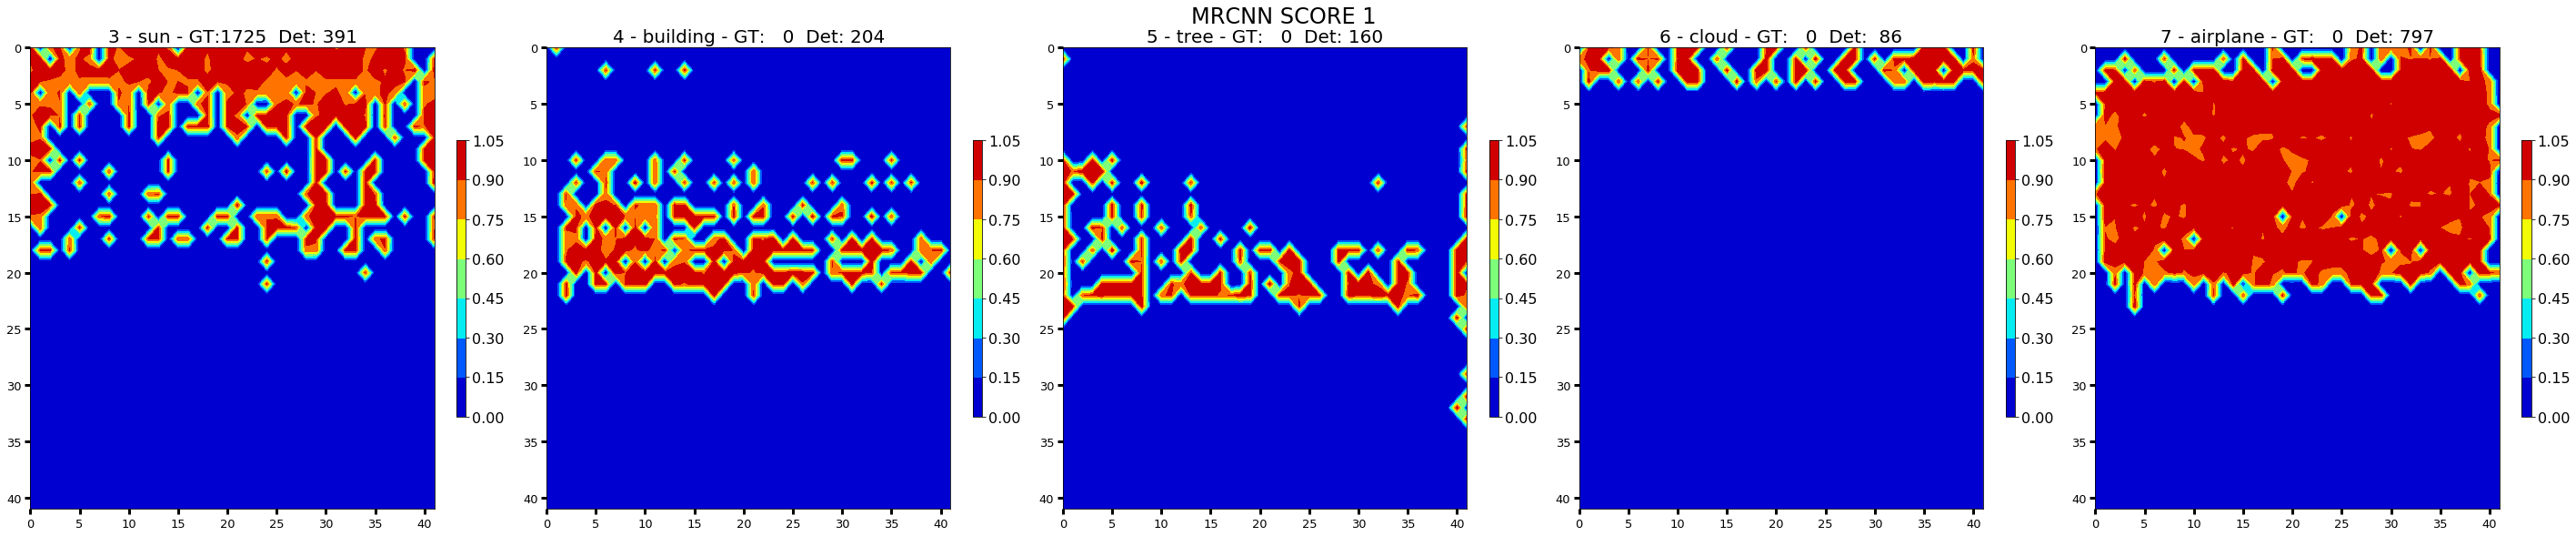

(9, 1, 1)


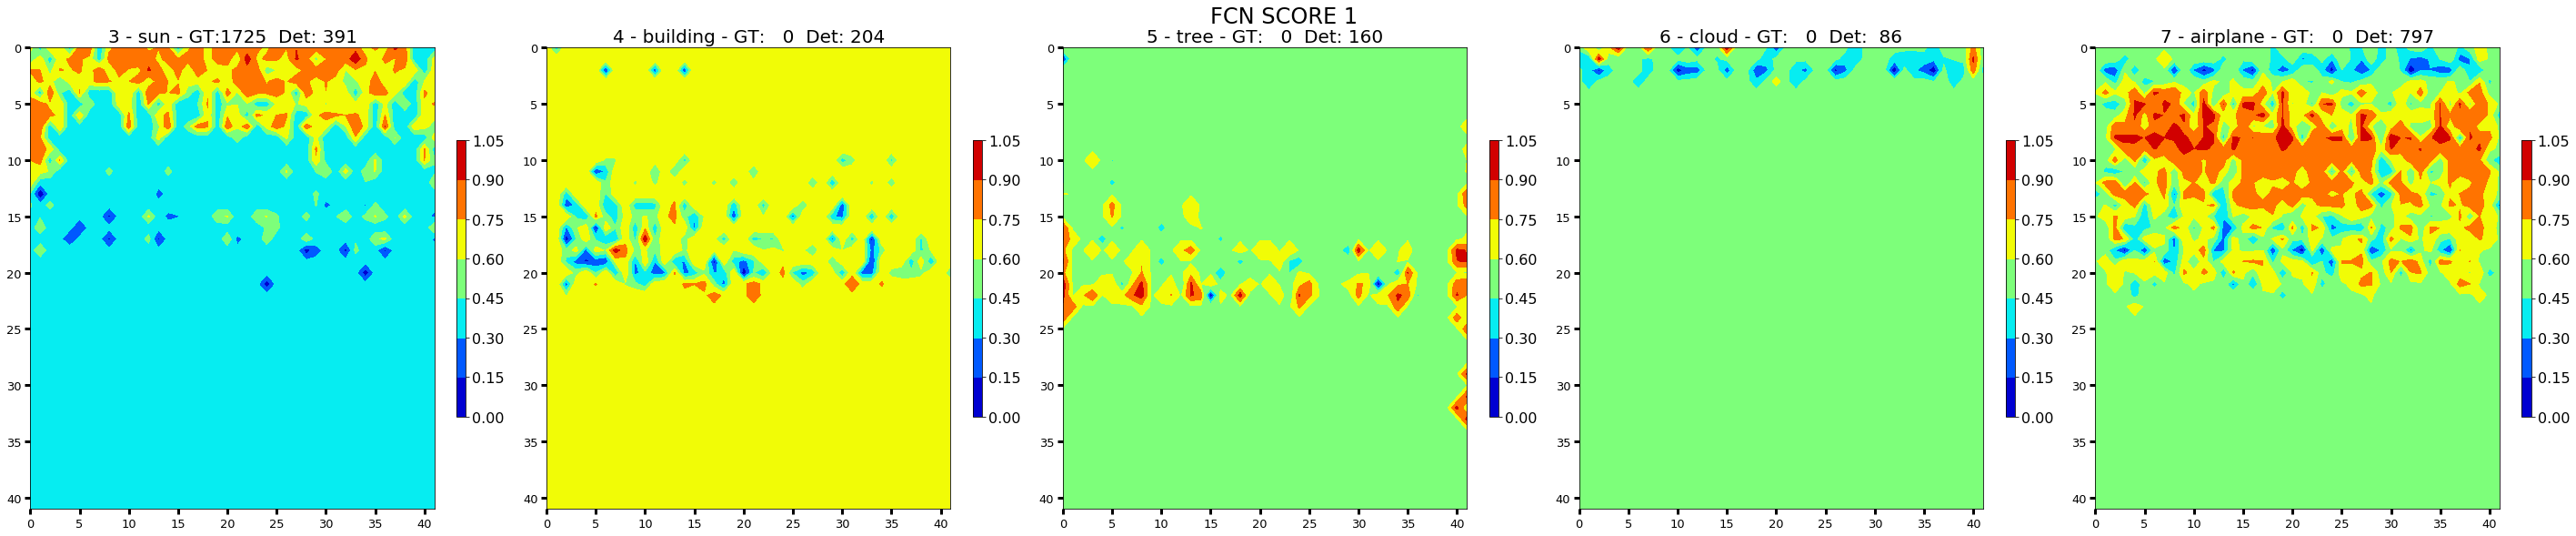

(9, 42, 42)


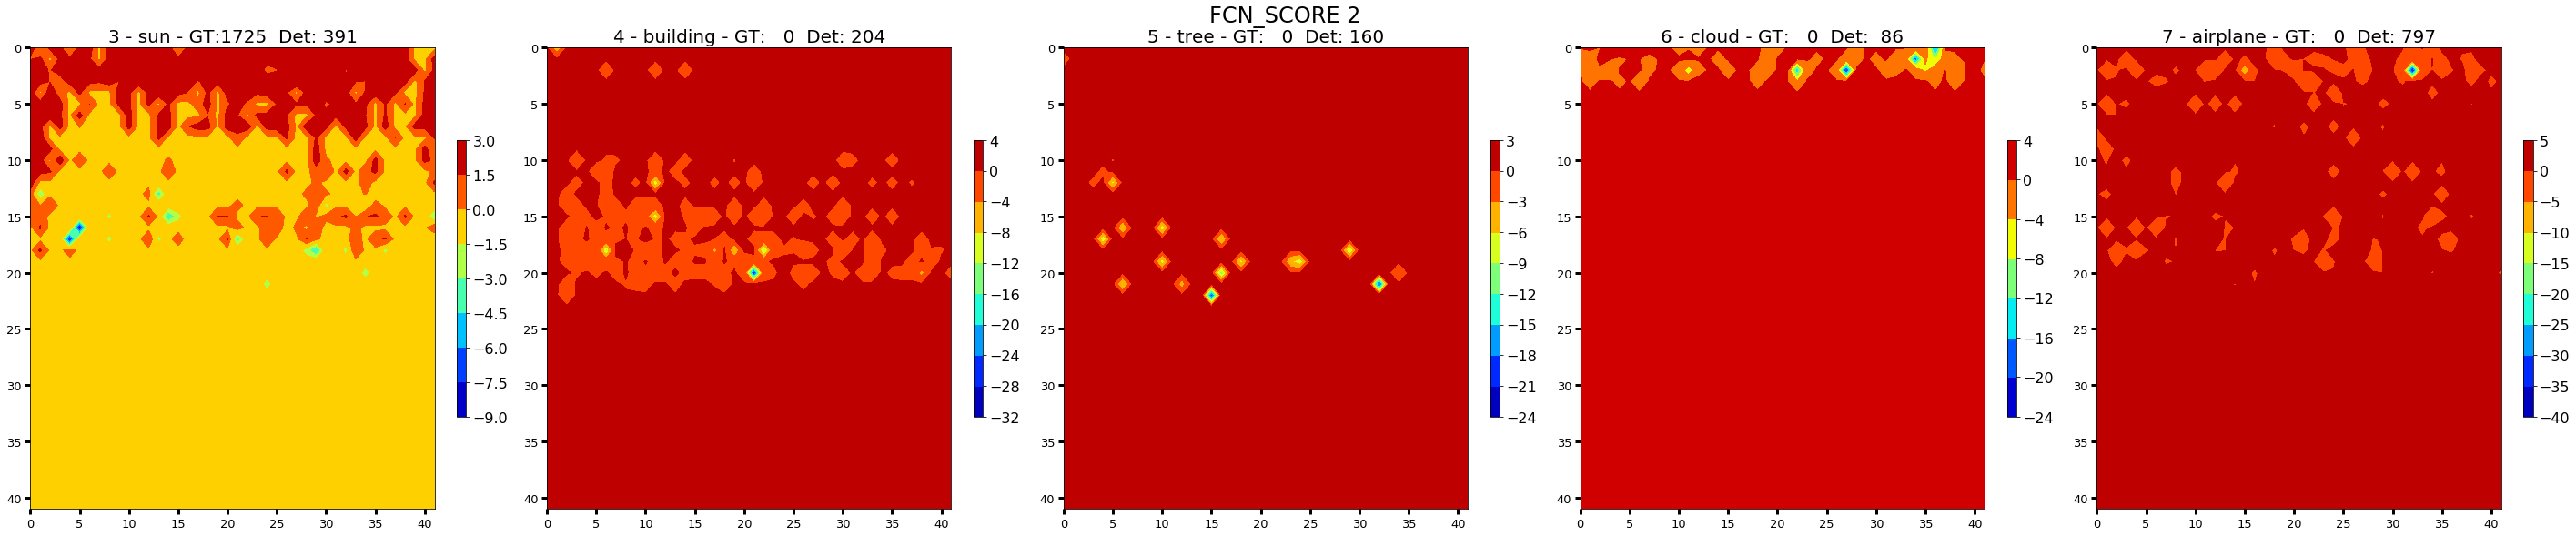

In [31]:
# print(ttl, cols)
# # classes = [1,2,3,4,5,6,7,8],2, keepdims=True
# classes = [2,3,4,6,7,8]
classes = [3,4,5,6,7]
# print(results['fcn_scores'][1].shape, p1.shape)
# p1 = np.linalg.norm(results['pr_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(pr_scores[0]) , gt_cls_counts, dt_cls_counts, class_names, title = 'MRCNN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['pr_scores'][0]/p1 , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)


# p1 = np.linalg.norm(results['fcn_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(fcn_scores[0]), gt_cls_counts, dt_cls_counts, class_names, title ='FCN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][0]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)


# p1 = np.linalg.norm(results['fcn_scores'][1],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.standardize_fcn_score(fcn_scores[1]), gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][1]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)

In [315]:
# classes = [2,3,4,6,7,8]
# # print(results['fcn_scores'][1].shape, p1.shape)
# p1 = np.linalg.norm(pr_scores[0],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(pr_scores[0]/p1 , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)
# p1 = np.linalg.norm(fcn_scores[0],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(fcn_scores[0]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)
# p1 = np.linalg.norm(fcn_scores[1],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(fcn_scores[1]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)

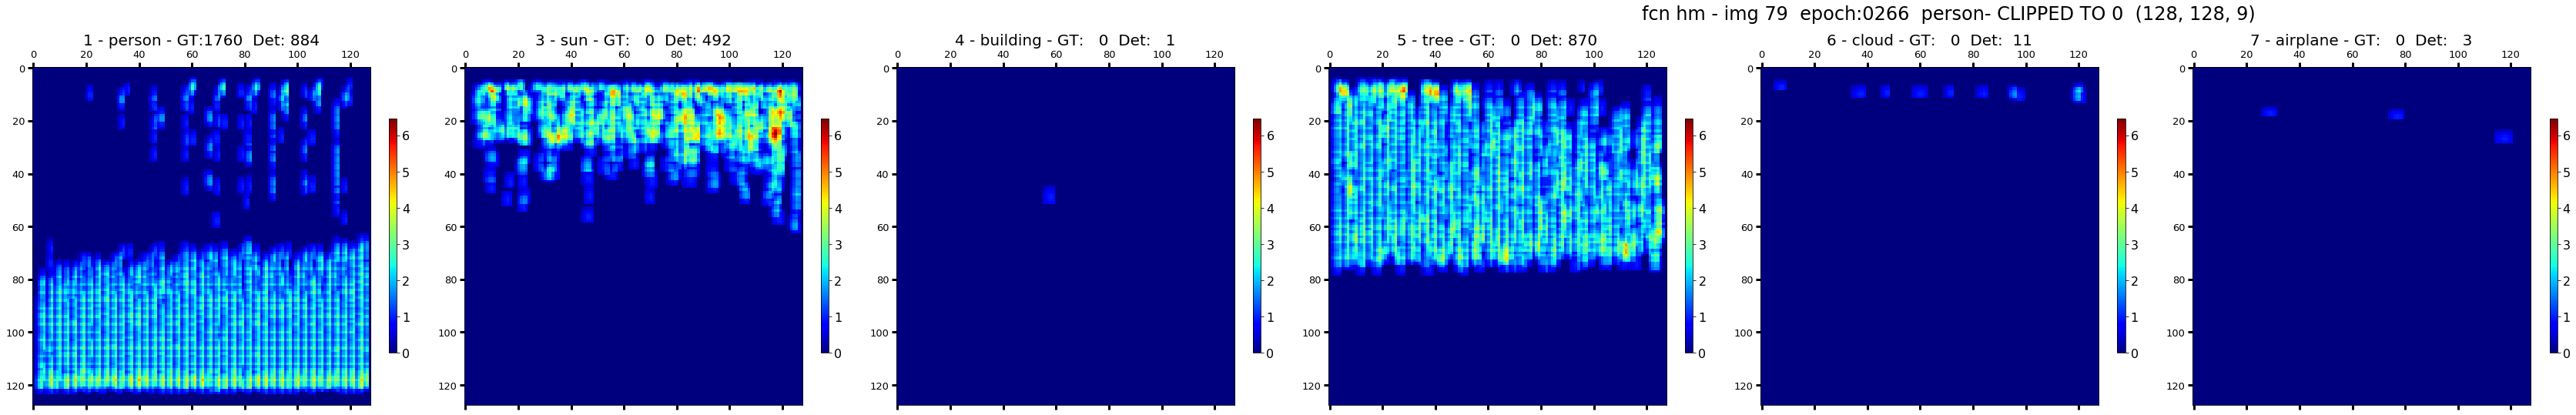

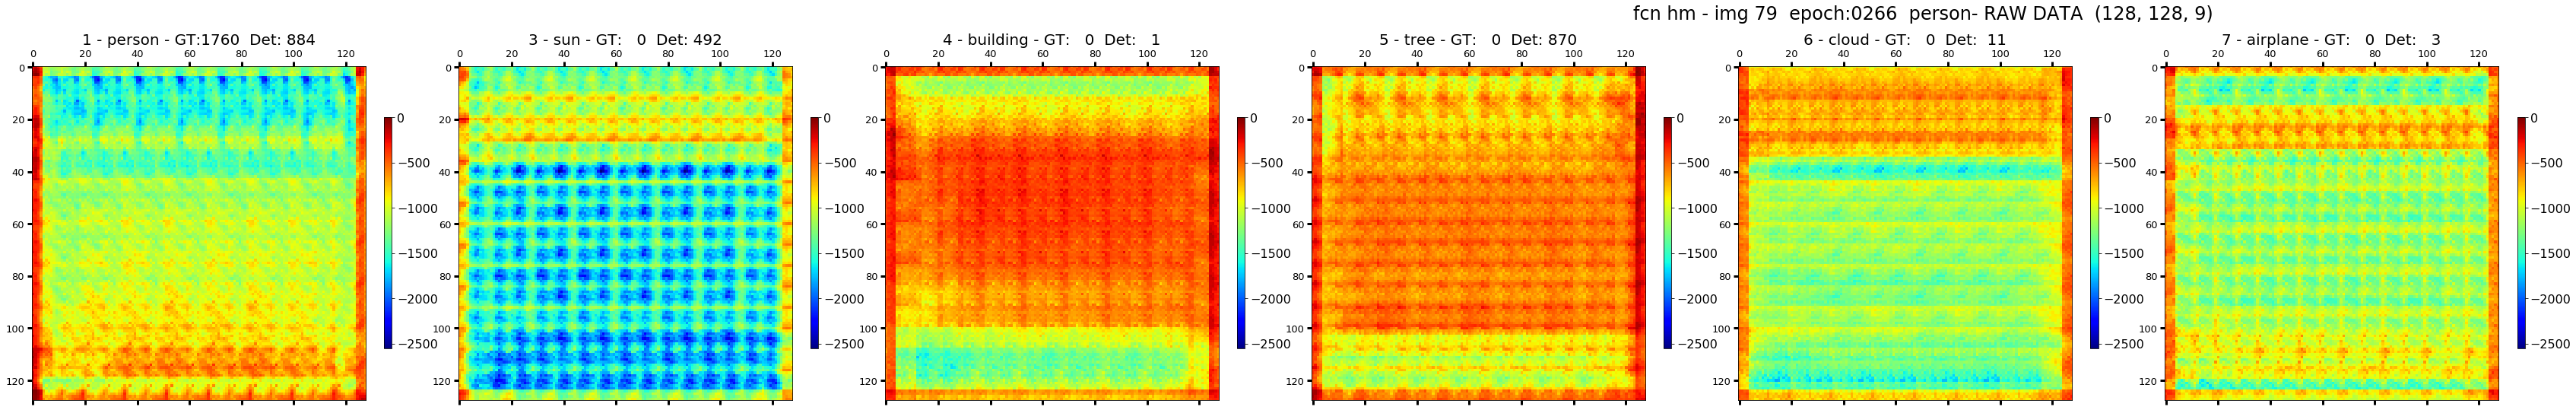

(128, 128, 9)


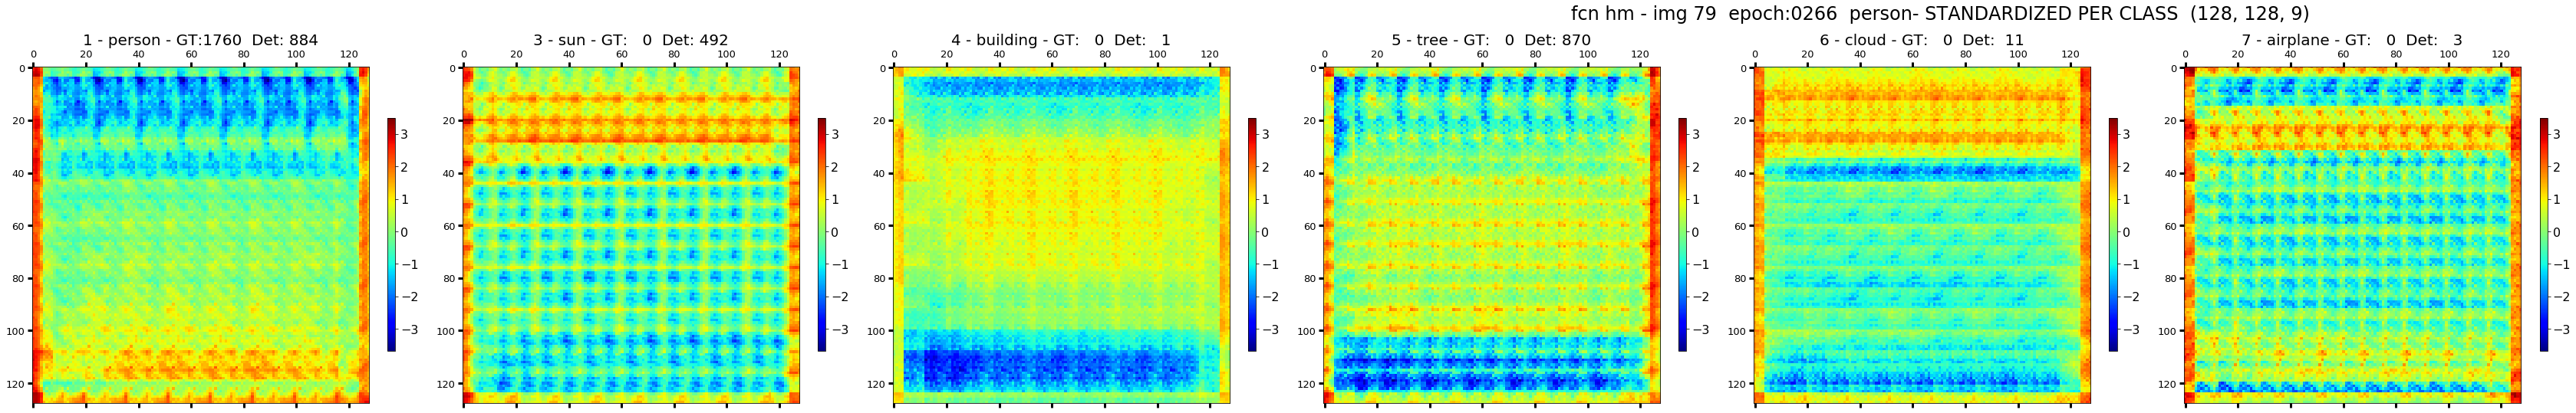

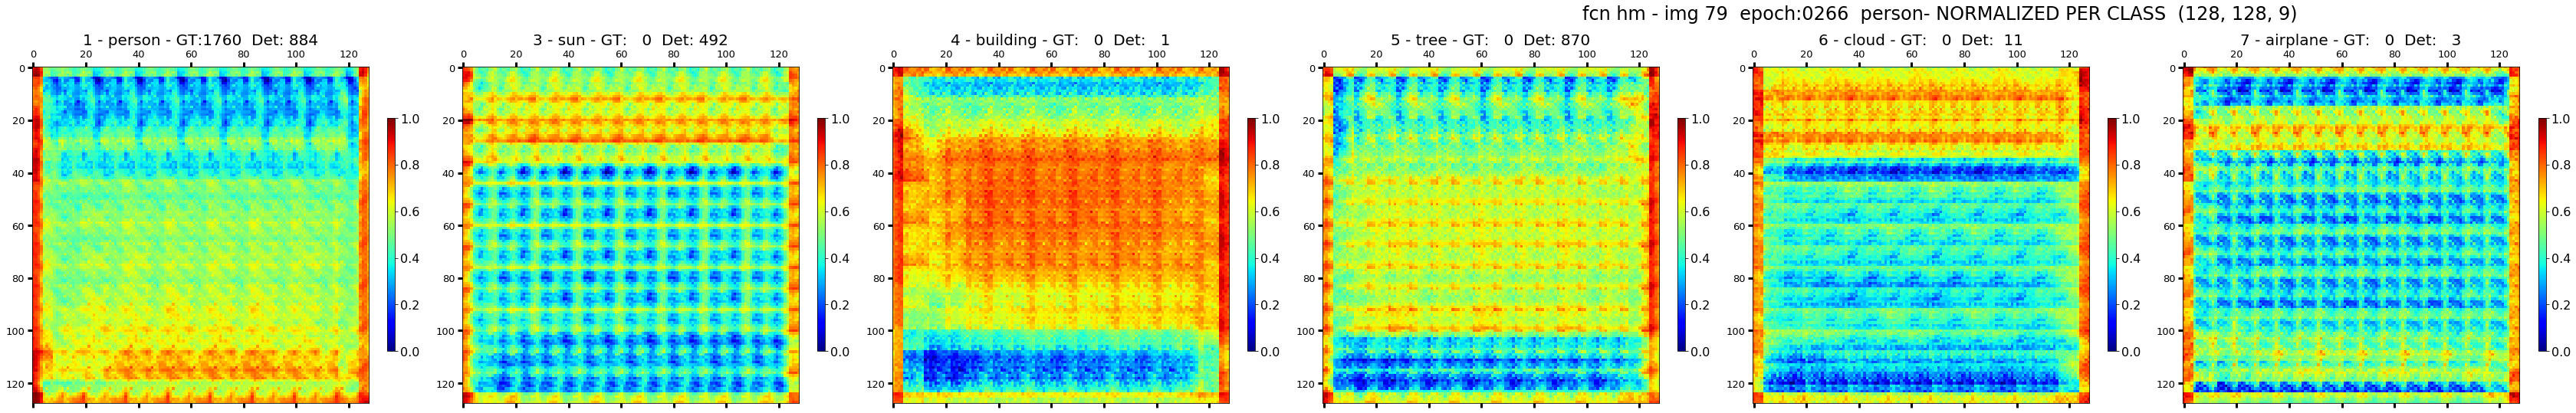

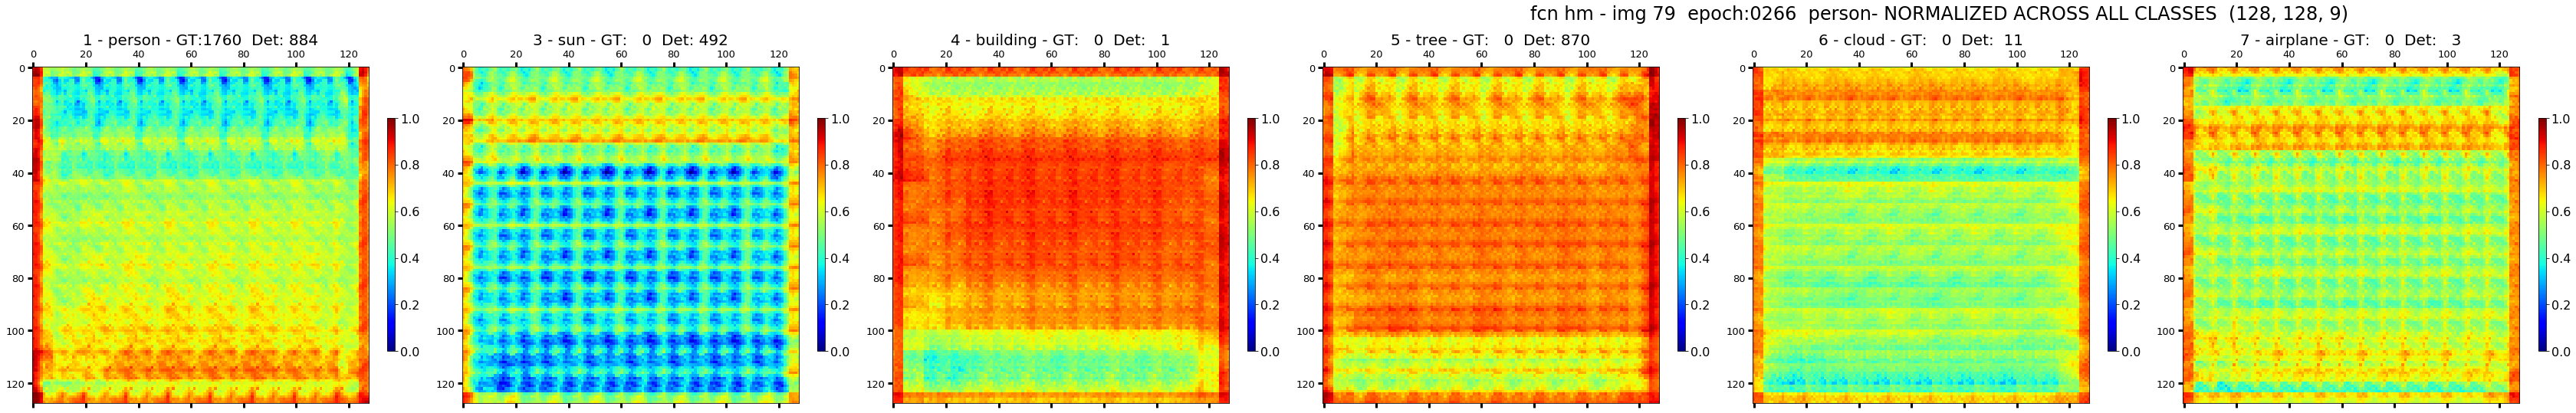

In [50]:
_ =vis2.display_fcn_agg_heatmaps(pr_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, columns =cols, title = ttl +'- CLIPPED TO 0 ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(pr_agg_hm, gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- RAW DATA ', norm = False, classes = classes)
# vis2.display_fcn_agg_heatmaps(vis2.deprocess_image(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- DEPROCESSED ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.standardize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- STANDARDIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED PER CLASS ', classes = classes)
_ = vis2.display_fcn_agg_heatmaps(vis2.normalize_all(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED ACROSS ALL CLASSES ', classes = classes)

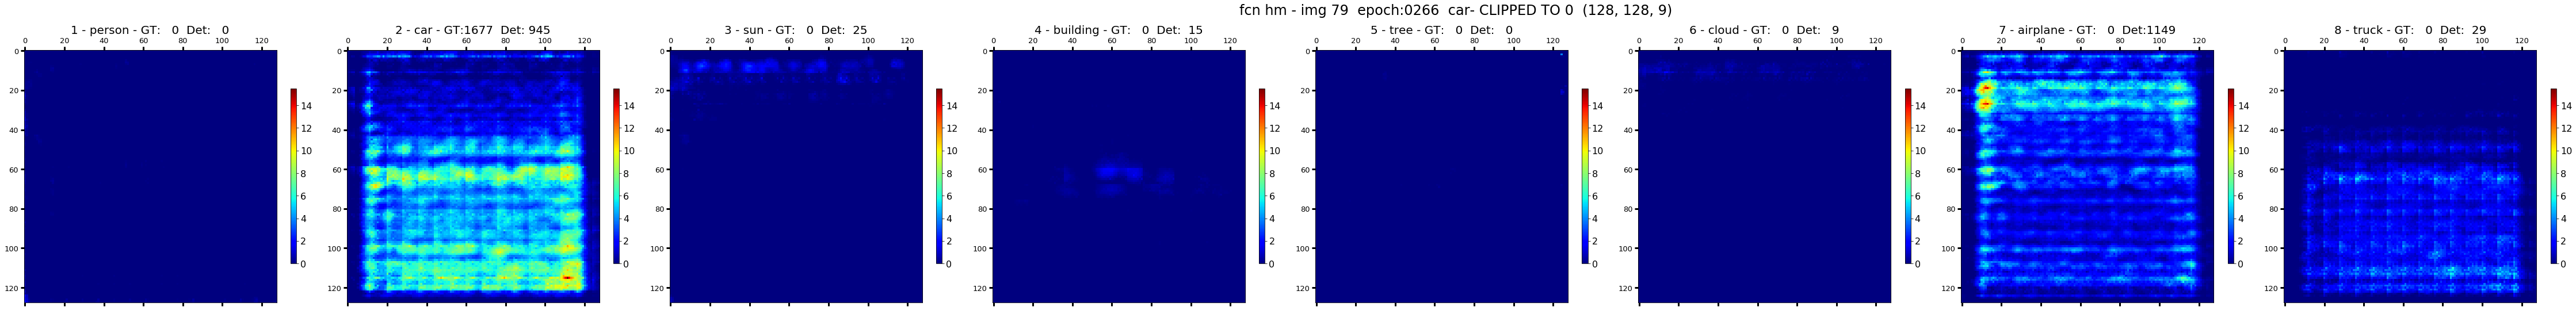

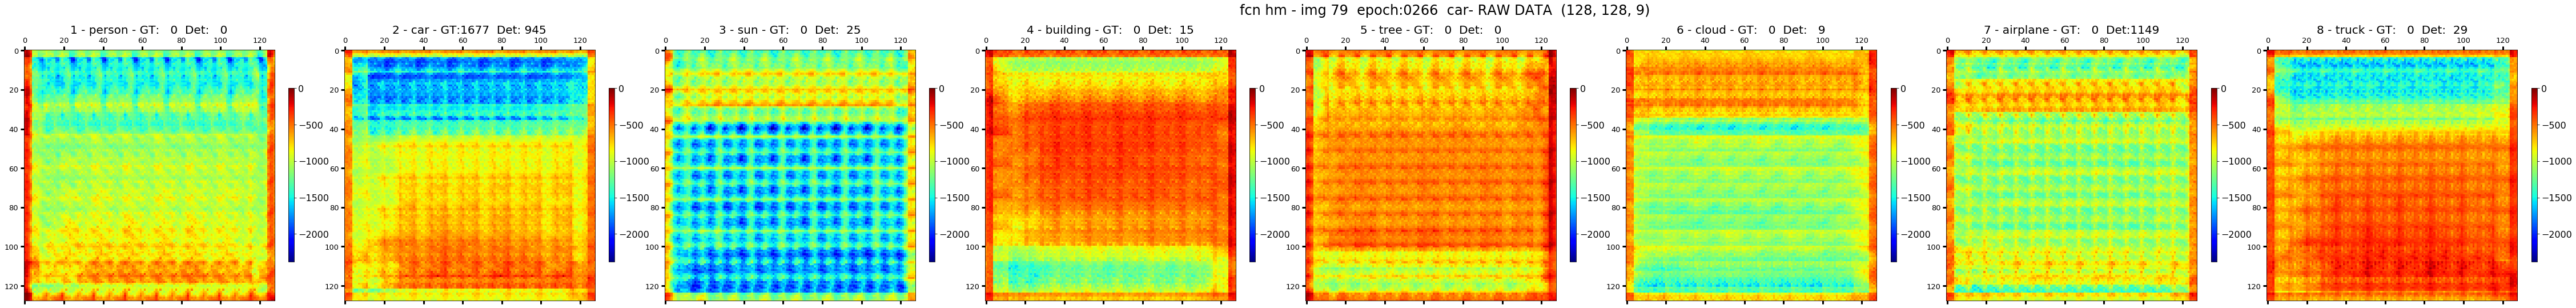

(128, 128, 9)


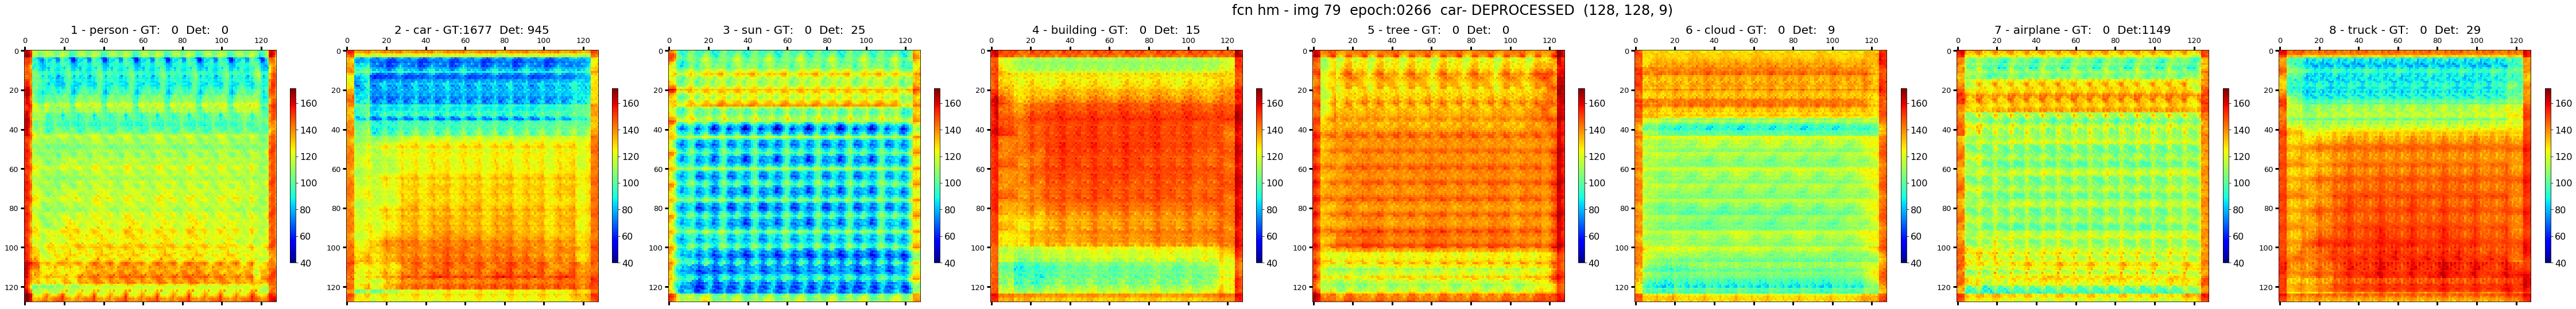

(128, 128, 9)


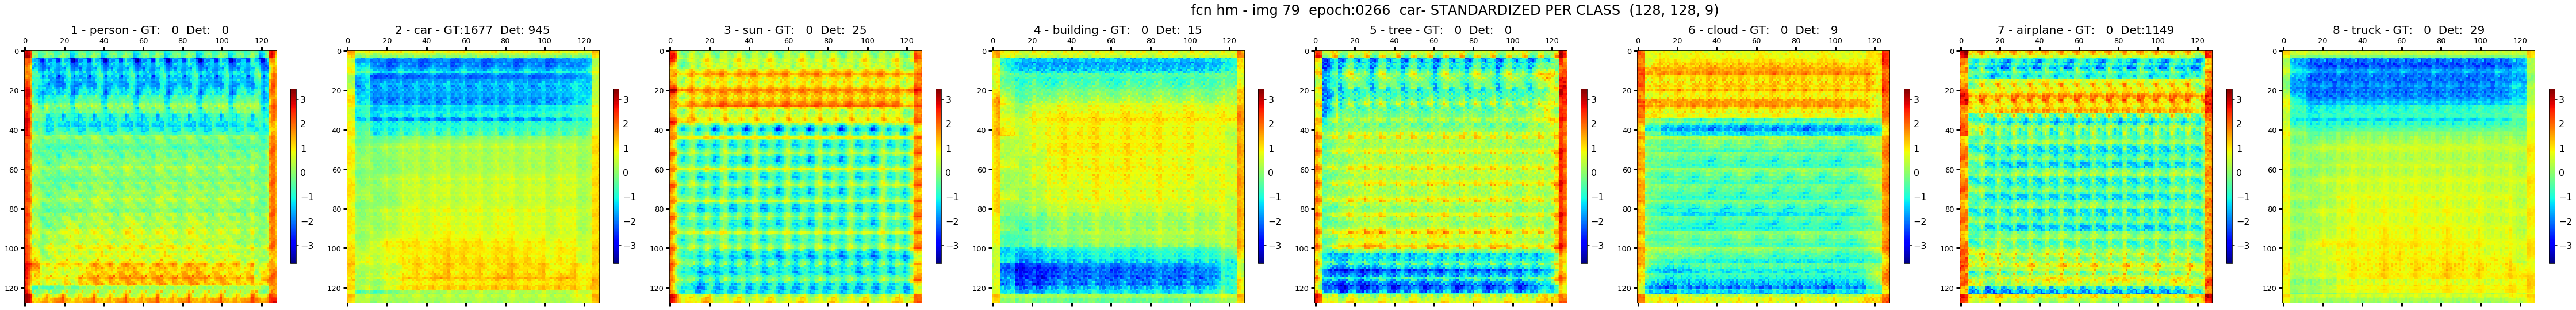

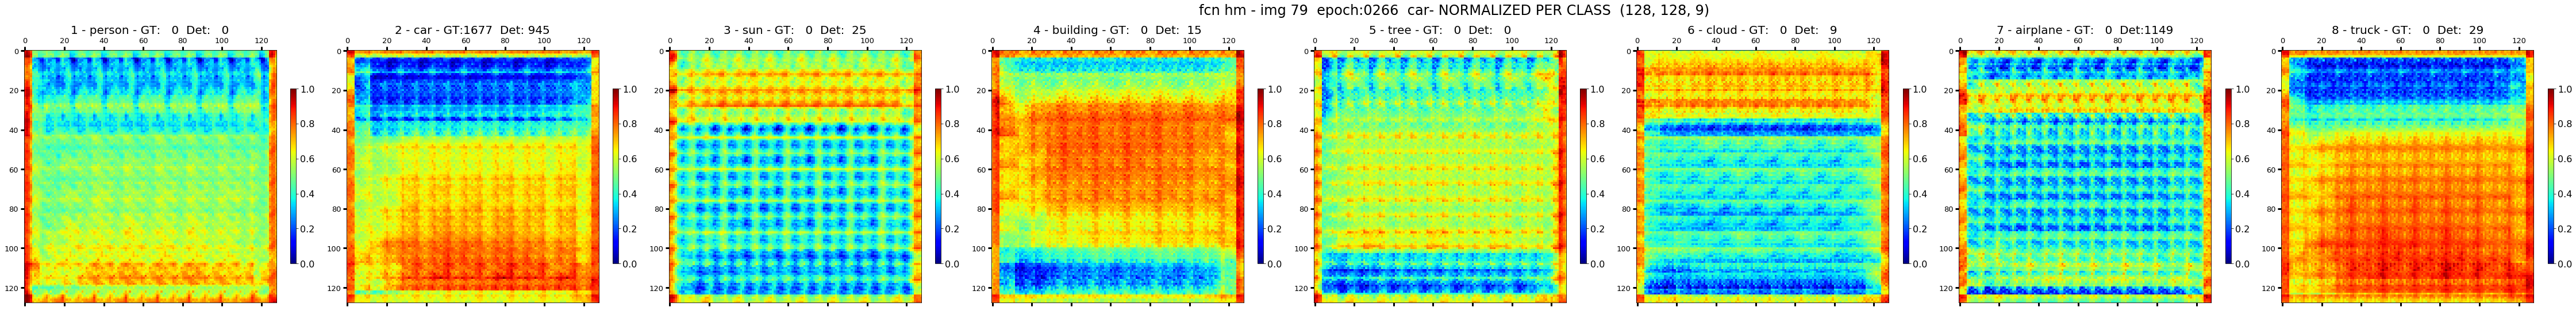

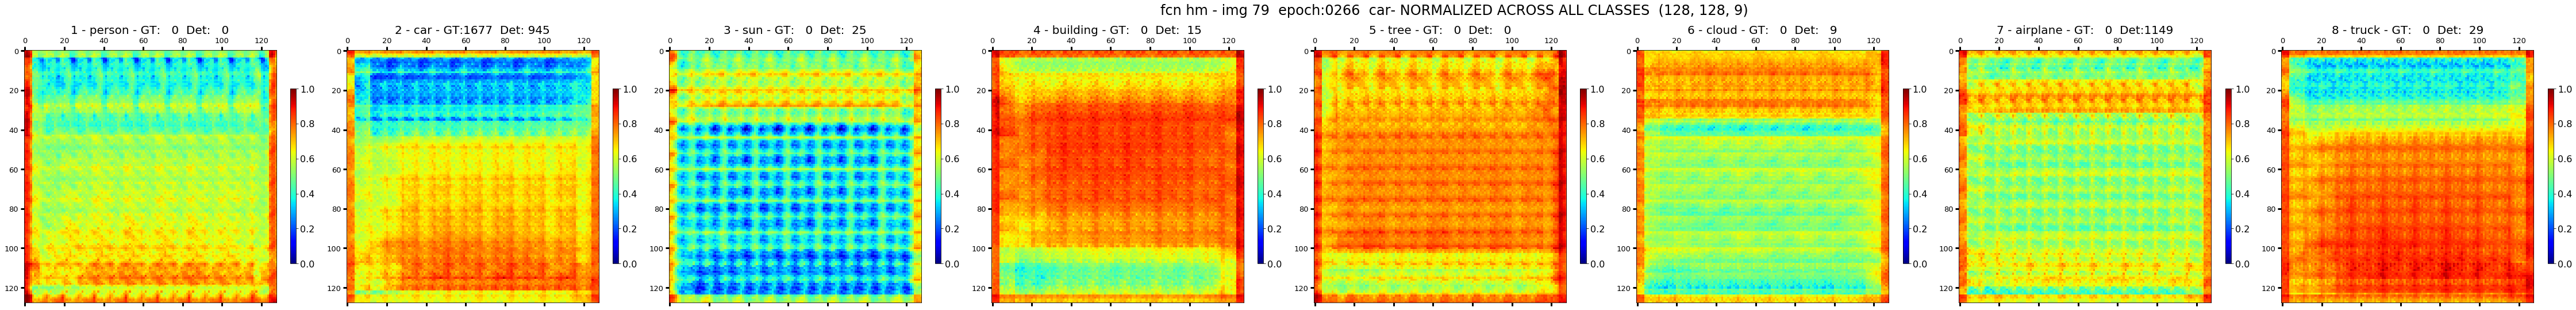

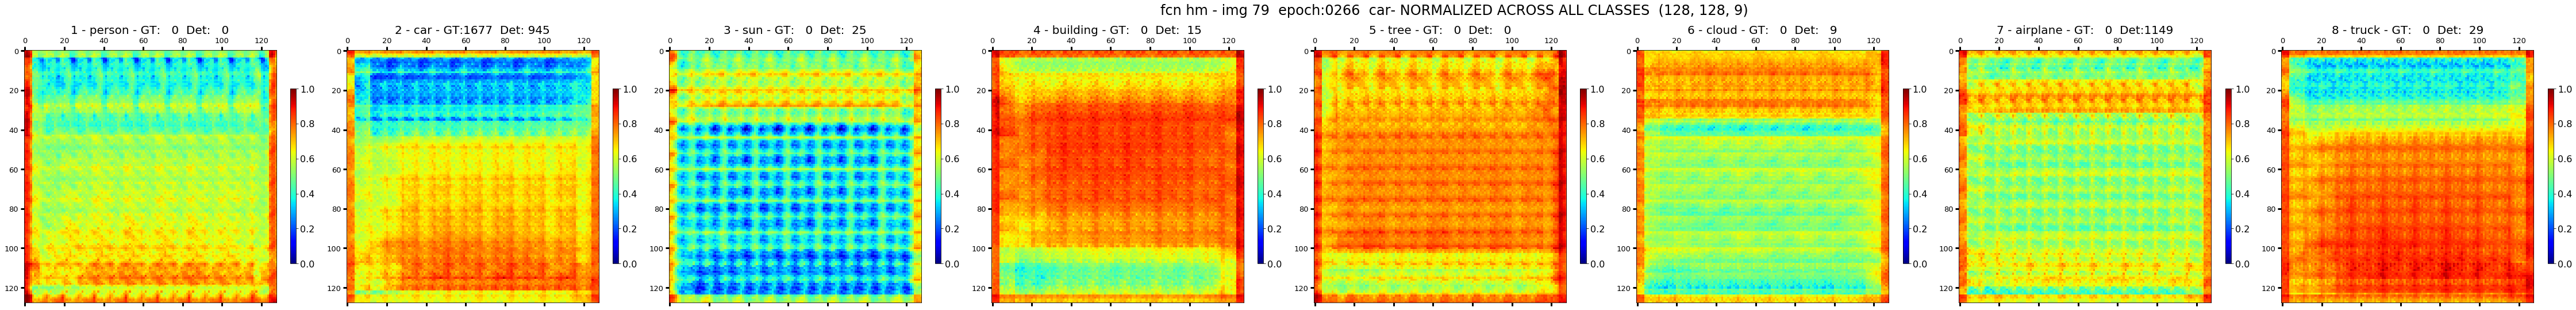

In [72]:
classes = [1,2,3,4,5,6,7,8]

_ =vis2.display_fcn_agg_heatmaps(fcn_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, columns =cols, title = ttl +'- CLIPPED TO 0 ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- RAW DATA ', norm = False, classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.deprocess_image(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- DEPROCESSED ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.standardize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- STANDARDIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_all(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED ACROSS ALL CLASSES ', classes = classes)

In [ ]:
delta = fcn_agg_hm_clipped - pr_agg_hm_clipped
vis2.display_fcn_agg_heatmaps(delta, gt_cls_counts, dt_cls_counts, class_names, columns =cols, title = ttl +'- CLIPPED TO 0 ', classes = classes)

In [ ]:
print(fcn_agg_hm.min(axis=(0,1), keepdims = True))
print(fcn_agg_hm.min( keepdims = True))


## Load and Display saved .npz file 

In [ ]:
# epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
epochs = '0266'
image_id =  176
load_file =  'exp2_img'+'_'+str(image_id)+'_epoch_'+epochs+'.npz'
print('  input file: ',os.path.join(save_path, load_file))

In [ ]:
loaddata = np.load(os.path.join(save_path, load_file))
# print(type(loaddata))
# print(loaddata.keys)
# print(type(loaddata['gt_ttl_img_by_inst']),'  ', type(loaddata['gt_ttl_img_by_inst'][0]))

gt_cls_counts      = loaddata['gt_cls_counts']  
dt_cls_counts      = loaddata['dt_cls_counts']  
# imgs_one_gt        = loaddata['imgs_one_gt']  
# imgs_one_dt        = loaddata['imgs_one_dt'] 
# gt_ttl_img_by_inst = loaddata['gt_ttl_img_by_inst']
# dt_ttl_img_by_inst = loaddata['dt_ttl_img_by_inst']
# sav_pr_min         = loaddata['sav_pr_min'] 
# sav_pr_max         = loaddata['sav_pr_max']  
# sav_fcn_min        = loaddata['sav_fcn_min']
# sav_fcn_max        = loaddata['sav_fcn_max']
pr_agg_hm          = loaddata['pr_agg_hm']
pr_agg_hm_clipped  = loaddata['pr_agg_hm_clipped']
fcn_agg_hm         = loaddata['fcn_agg_hm']
fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']

print('Agg heatmap Calcs complete for epoch:', epochs , ' (heatmap file:', load_file, ')')
# display_results(loaddata)

## Display Heatmaps

In [ ]:
# hmfig = vis2.display_pairwise_heatmap(gt_ttl_img_by_inst, [0,1,2,3,4,5,6,7,8], class_names)

### mask_rcnn output

In [ ]:
classes = [1,2,3,4,5,6,7,8]
vis2.display_fcn_input(pr_agg_hm, gt_cls_counts, dt_cls_counts, class_names, classes = classes, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT clipped ')
vis.plot_2d_gaussian(pr_agg_hm[:,:,1], size =(5,5), title = 'MRCNN produced heatmap')

### mask_rcnn output - normalized

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT clipped ')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(pr_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis.display_image_gt(dataset_test, dataset_test.config, image_id , size = 5, verbose = False)   

### mask_rcnn output - standarize and clip

In [ ]:
vis2.display_fcn_input_1(vis2.standardize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - Standardized - ')
vis2.display_fcn_input_1(vis2.deprocess_image(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT Clipped - Normalized - ')

###  mask_rcnn clipped  
(pr_agg_hm_clipped is same as pr_agg_hm since the ouptut of R-CNN is [0,1]

In [ ]:
vis2.display_fcn_input_1(pr_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names , cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0 ,1]')

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(pr_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0,1] and Normalized - ')

In [ ]:
vis2.display_fcn_input_1(vis2.deprocess_image(pr_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0,1] and Normalized - ')

###  fcn

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

### fcn normalized

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - NOT clipped to [0,1],  Normalized -')

### fcn clipped

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - clipped to [0,1] - ')

### fcn clipped - normalized

In [ ]:
# vis2.display_fcn_input_1(vis2.deprocess_image(fcn_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - clipped to [0 ,1] and Normalized - ')

##  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
visualize.plot_3d_heatmap(model_gt_heatmap, img_id, gt_class_ids, class_names = coco_class_names, scaling='class')

####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_pr_heatmap, img_id, pr_class_ids, class_names = coco_class_names, zlim = 'class' , scaling = 'none')

####  3D plot of `fcn_heatmap` returned form model - only classes in pred_scores

In [ ]:
print(np.max(model_fcn_heatmap), np.min(model_fcn_heatmap))

print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_fcn_heatmap, img_id, pr_class_ids,class_names = coco_class_names, scaling = 'none')

####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
visualize.plot_3d_heatmap(model_fcn_heatmap, img_id, class_names = coco_class_names, columns = 3,scaling = 'all')

####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap_compare(model_pr_heatmap, model_fcn_heatmap, img_id, class_ids = pr_class_ids, 
                            class_names = coco_class_names, size=(8,8), zlim = 'all' , scaling = 'all')

####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
visualize.plot_3d_heatmap_compare(model_gt_heatmap, model_fcn_heatmap, img_id, gt_class_ids, class_names = coco_class_names, scaling = 'none')